# Data quality checks

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import h5py
from os import path
import pickle
import pwca

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from Welsh Puck (aka pwca).
(pwca.core)>> Catalog of calibration runs stored to "pwca.pwca_catalog"
(pwca.core)>> Metadata dictionary for calibration runs stored to "pwca.metadata_dict"


In [3]:
#
offending_run = 'q8a08t90dP0_T_96_384'
# Find select simulations using scsearch
a = scsearch( keyword=offending_run, verbose= True, unique=True, catalog=pwca.pwca_catalog )[0]

(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found keyword (=q8a08t90dP0_T_96_384) keyword.
(scsearch)>> Found unique (=True) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 unique simulations:
[0001][hogshead] q8: 1chi0.80-p-q8.00	(q8a08t90dP0_T_96_384)



In [135]:
# Define loading parameters 
lmax = 2
pad = 1000
clean = True
dt = 0.5

# Load
y_raw = gwylm(a,lmax=lmax,dt=dt,pad=pad,clean=clean,verbose=True)

(gwylm)>> Found clean (=True) keyword.
(gwylm)>> Found dt (=0.5) keyword.
(gwylm)>> Found enforce_m_relative_sign_convention (=True) keyword.
(gwylm)>> Found lmax (=2) keyword.
(gwylm)>> Found load_dynamics (=True) keyword.
(gwylm)>> Found pad (=1000) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x10f10ec30>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(__init__)>> Using default M_RELATIVE_SIGN_CONVENTION of 1
(gwylm)>> The (extraction_parameter,level) is (5,7), which differs from the config values of (5,5). You have either manually input the non-config values, or the handler has set them by looking at the contents of the simulation directory. 
(__make_lmlist__)>> The following spherical multipoles will be loaded:[(2, 2), (2, -2), (2, -1), (2, 0), (2, 1)]
(load)>> Using the default extraction_parameter of 5
(load)>> Using the default level of 7
(load)>> Loading: psi3col.r5.l7.l2.m2.gz
(load)>> Padding wfarr. The old data length was 5048, and the n

In [136]:
# Manage frames using dict defined below
frame = {}
frame['raw'] = y_raw

# Put in initial J frame
frame['init-j'] = y_raw.__calc_initial_j_frame__()

# Compute TD adn FD coprecessing psi4 frames
frame['cp-y-fd'] = frame['init-j'].__calc_coprecessing_frame__( transform_domain='fd', kind='psi4' )
frame['cp-y-td'] = frame['init-j'].__calc_coprecessing_frame__( transform_domain='td', kind='psi4' )
frame['cp-h-td'] = frame['init-j'].__calc_coprecessing_frame__( transform_domain='td', kind='strain' )

# Symmetrise data
foo = dict(frame)
for k in frame:
    if 'cp' in k:
        foo['sym-'+k] = frame[k].__symmetrize__()
#
frame = foo

(__calc_initial_j_frame__)>> Using bbh data for initial J.
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.
(__calc_coprecessing_frame__)>> We will use psi4 to compute the co-precessing frame.
(__calc_coprecessing_frame__)>> Transforming to the coprecessing frame using FD angles.
(calc_coprecessing_angles)>> The domain values seem evenly split between positive and negative values. Thus, we will interpret the input as corresponding to FREQUENCY DOMAIN data.
(__calc_coprecessing_frame__)>> Storing radiation axis information to this.radiation_axis_info
(__rotate_frame_at_all_times__!)>> Note that metadata vectors for initial data will be rotated according to positive frequency angles.
(__rotate_frame_at_all_times__)>> Attempting to

In [44]:
from scipy.signal import hilbert

In [52]:
??smooth

Init signature: smooth(this, y, width=None, method=None, auto_method=None, polynomial_order=2)
Source:        
class smooth:
    '''
    Smooth 1D data. Initially based on https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
    '''

    # Class constructor
    def __init__(this,y,width=None,method=None,auto_method=None,polynomial_order=2):
        # Import useful things
        from numpy import ones,convolve,mod,hstack,arange,cumsum,mod,array
        # Handle method input; set default
        width = max(10,int(len(y)/10.0)) if width is None else width
        method = 'savgol' if method is None else method.lower()
        # # Handle n input; default is None which causes method to be auto
        # method = 'auto' if width is None else method
        # Store relevant inputs to this object
        this.scalar_range = array(y)
        this.width = width
        this.method = method

        # Handle different methods
        if method in ('average','avg',

(-0.001, 0.001)

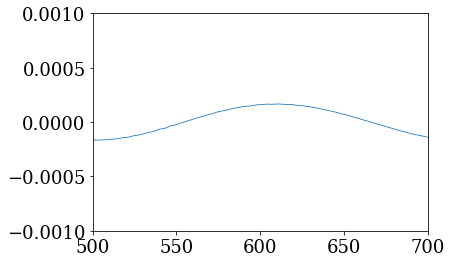

In [90]:
plot( g.plus )
xlim( 400+array([100,300]) )
ylim(0.001*array([-1,1]))

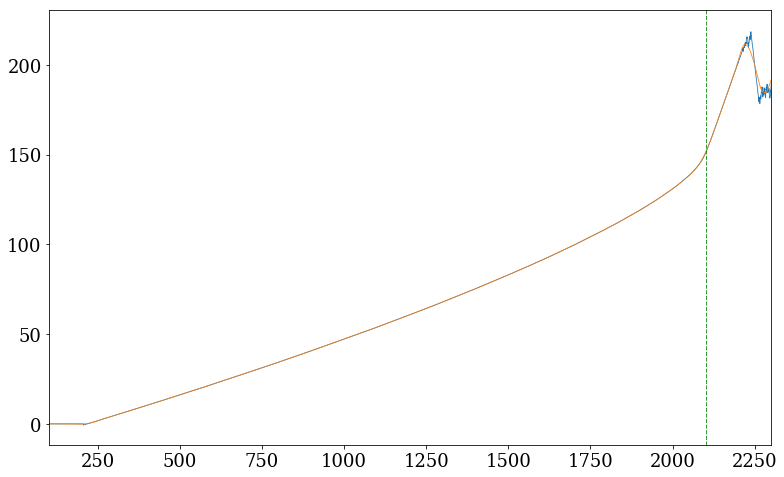

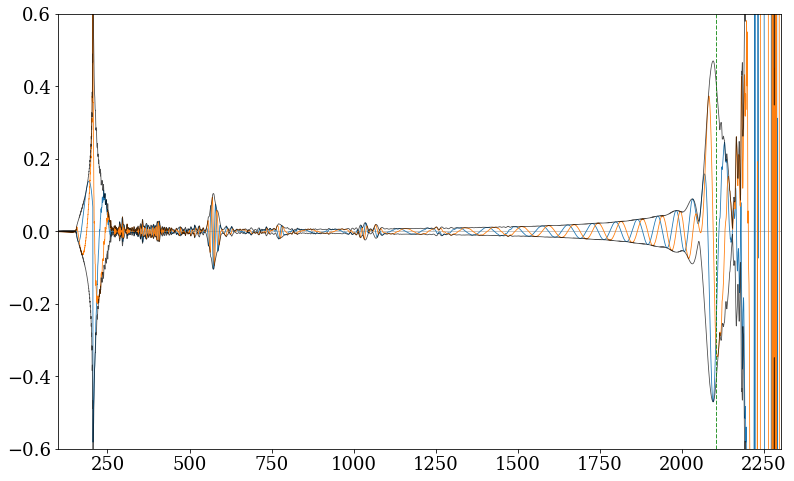

In [137]:
g = frame['sym-cp-y-td'][2,2]['psi4']

# z = hilbert( g.dphi )

figure( figsize=2*figaspect(0.618) )

plot( g.t, g.phi )
plot( g.t, smooth(g.phi,method='savgol',width=200).answer )
# plot( g.t, z.real )
# plot( g.t, z.imag )
xlim( 100, 2300 )
# ylim( 0.6*array([-1,1]) )
axvline( g.t[g.k_amp_max], ls='--', color='g' )

figure( figsize=2*figaspect(0.618) )

# plot( g.t, g.phi )
plot( g.t, 0*g.t, color='k', alpha=0.3 )
x = g.phi-smooth(g.phi,method='savgol',width=200).answer
z = hilbert(x)
# plot( g.t, x )
plot( g.t, z.real )
plot( g.t, z.imag )
plot( g.t, abs(z), color='k', alpha=0.7 )
plot( g.t,-abs(z), color='k', alpha=0.7 )

xlim( 100, 2300 )
ylim( 0.6*array([-1,1]) )
axvline( g.t[g.k_amp_max], ls='--', color='g' )

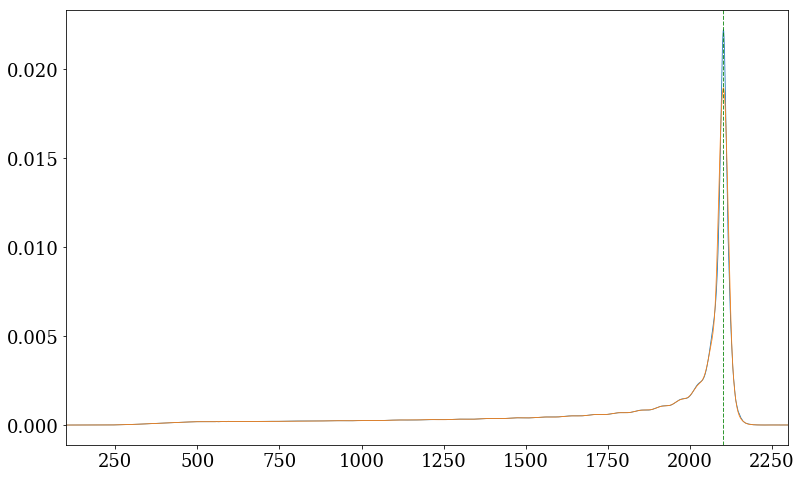

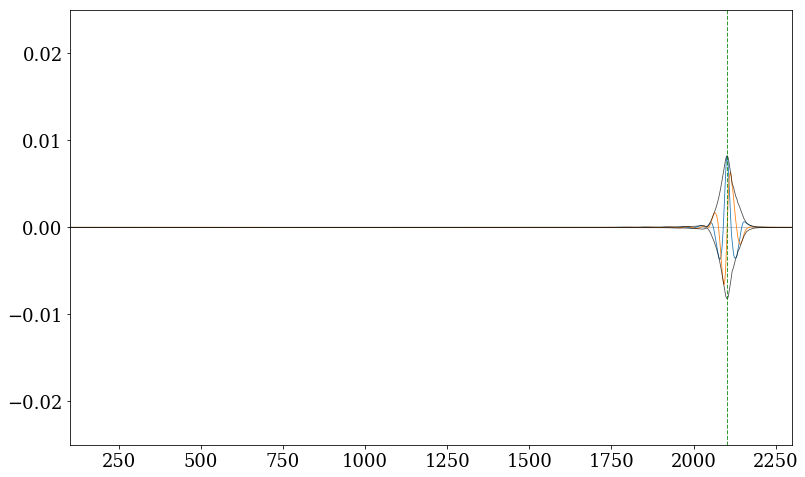

In [138]:
g = frame['sym-cp-y-td'][2,2]['psi4']

# z = hilbert( g.dphi )

figure( figsize=2*figaspect(0.618) )

plot( g.t, g.amp )
plot( g.t, smooth(g.amp,method='savgol',width=100).answer )
# plot( g.t, z.real )
# plot( g.t, z.imag )
xlim( 100, 2300 )
# ylim( 0.6*array([-1,1]) )
axvline( g.t[g.k_amp_max], ls='--', color='g' )

figure( figsize=2*figaspect(0.618) )

# plot( g.t, g.phi )
plot( g.t, 0*g.t, color='k', alpha=0.3 )
x = g.amp-smooth(g.amp,method='savgol',width=200).answer
z = hilbert(x)
# plot( g.t, x )
plot( g.t, z.real )
plot( g.t, z.imag )
plot( g.t, abs(z), color='k', alpha=0.7 )
plot( g.t,-abs(z), color='k', alpha=0.7 )

xlim( 100, 2300 )
ylim( 0.025*array([-1,1]) )
axvline( g.t[g.k_amp_max], ls='--', color='g' )

In [139]:
print 2*(1/(frame['sym-cp-y-td'].wstart/(2*pi)))*frame['sym-cp-y-td'].dt

106.3779434108246


In [140]:
#
def __savgol_clean_phase__(gwfo, smooth_width=100, plot=False, verbose=False):
    
    '''
    Given gwf class object, apply savgol filter to phase with realted width determined by lowest frequency within data. After phase has been cleaned, regenerate gwf fields.
    '''
    
    #
    from scipy.signal import hilbert 
    from positive import smooth 
    
    #
    t = gwfo.t
    amp = gwfo.amp
    phi = gwfo.phi
    
    #
    cleaned_phi = smooth(phi,method='savgol',width=smooth_width).answer
    cleaned_y = amp * exp( 1j * cleaned_phi )
    cleaned_wfarr = array( [ t, cleaned_y.real, cleaned_y.imag ] ).T 
    
    #
    cleaned_gwfo = gwfo.copy()
    cleaned_gwfo.setfields(wfarr=cleaned_wfarr)
    
    #
    return cleaned_gwfo
    

In [161]:
cg = __savgol_clean_phase__(g,smooth_width=300)

([<matplotlib.axes._subplots.AxesSubplot at 0x15c5bac10>,
 <Figure size 633.6x570.24 with 3 Axes>)

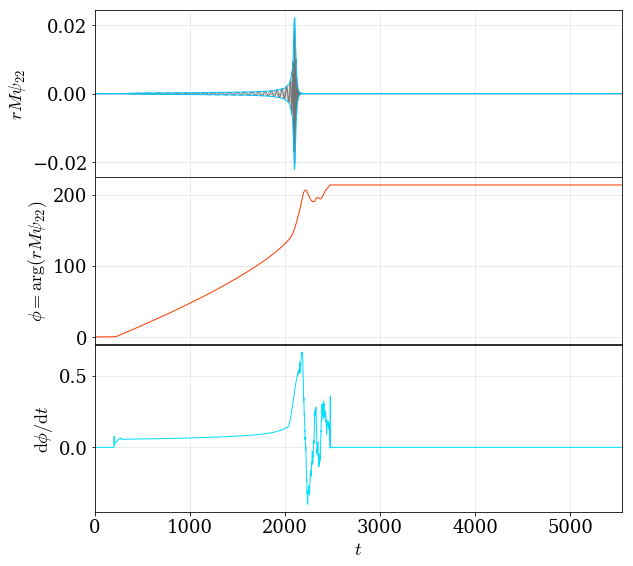

In [162]:
cg.plot()

(0.0, 0.5)

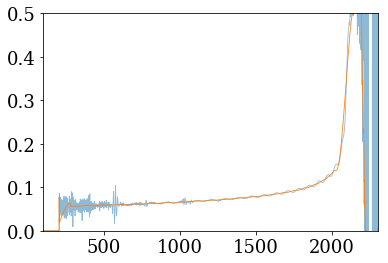

In [163]:

plot( cg.t, g.dphi, alpha=0.5 )
plot( cg.t, cg.dphi )
xlim( 100, 2300 )
ylim( 0.5*array([0,1]) )

(-13500, -12500)

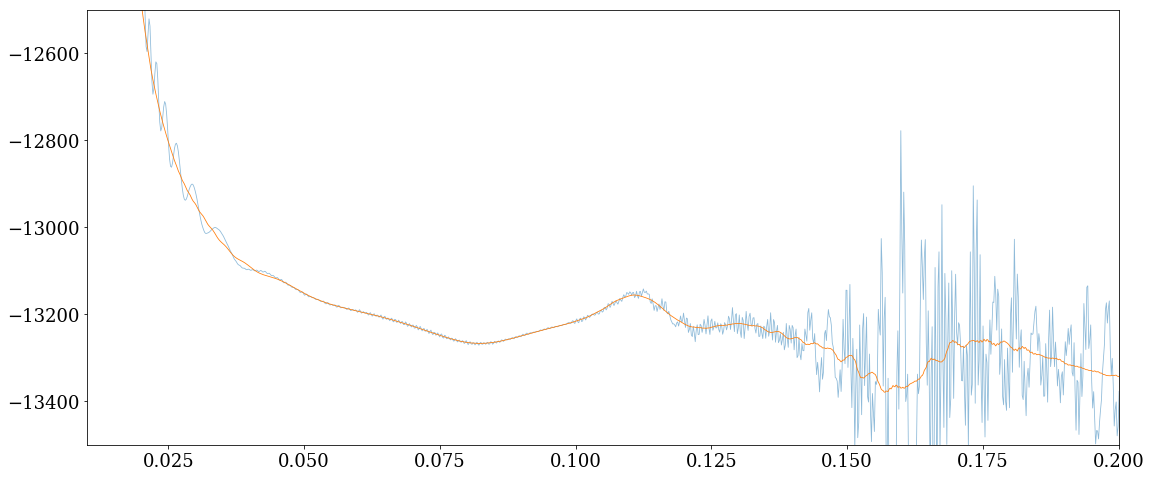

In [178]:
figure( figsize=2*figaspect(0.618*.7) )
plot( cg.f, g.fd_dphi, alpha=0.5 )
# plot( cg.f, smooth(g.fd_dphi,method='auto',auto_method='savgol').answer )
plot( cg.f, smooth(g.fd_dphi,method='savgol',width=90).answer )
xlim( 0.01, 0.2 )
ylim( -13500,-12500 )

Signature: g.plot(show=False, fig=None, title=None, ref_gwf=None, labels=None, tlim=None, sizescale=1.1, flim=None, ax=None, domain=None)
Docstring: <no docstring>
File:      ~/JOKI/Libs/KOALA/nrutils_dev/nrutils/core/nrsc.py
Type:      instancemethod


(-15000, -10000)

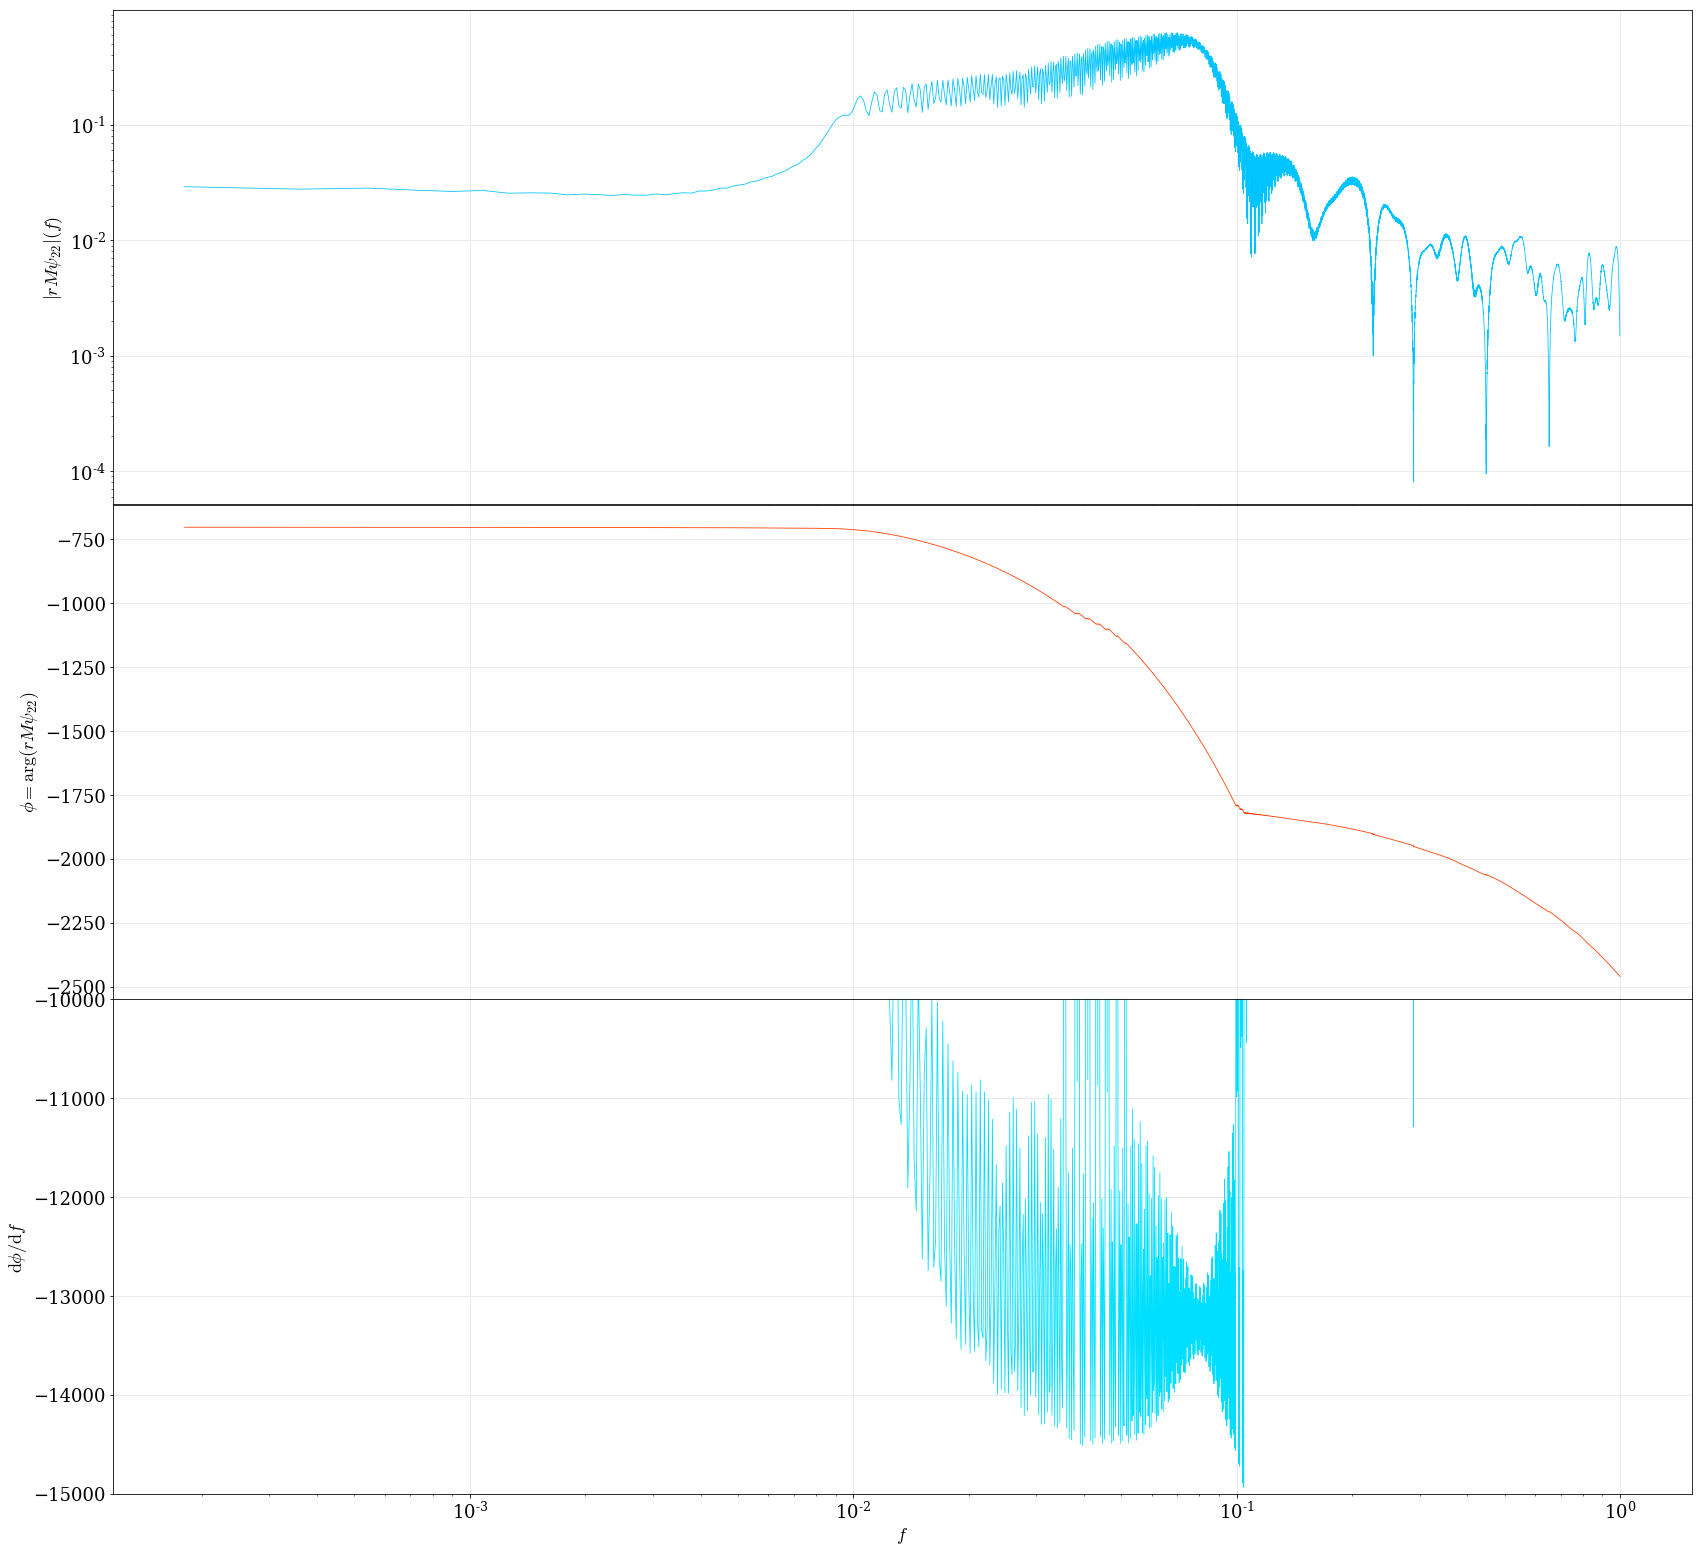

In [34]:
g = frame['sym-cp-y-td'][2,2]['psi4']
ax,fig = g.plot(domain='freq',sizescale=3)
sca(ax[-1])
ylim(-15000,-10000)
# xlim( g.t[g.k_amp_max]-500, g.t[g.k_amp_max]+200 )

In [35]:
y = frame['cp-y-td']


# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(make_pnnr_hybrid)>> Validating inputs
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(__validate_inputs__)>> Verbose mode ON.
(__validate_inputs__)>> Valid gwylm object found. Its simulation name is "q8a08t90dP0_T_96_384".
(__validate_inputs__)>> PN w_orb MIN frequency is 0.019854 (i.e. w_orb*M_init)
(__validate_inputs__)>> PN w_orb MAX frequency is 0.116417 (i.e. w_orb*M_init)

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(make_pnnr_hybrid)>> Generating PN multipoles
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(pn)>> Now constructing instance of the pn class.
(pn)>> Defining the initial binary state based on inputs.
(__validative_constructor__)>> Rescaling masses so that m1+m2=1
(__calc_orbital_frequency__)>> Calculating evolution of orbital phase using RK4 steps.
(__calc_com_binding_energy__)>> Calculating COM binding energy
(__calc_total_angular_momentum__!)>> This function currently only

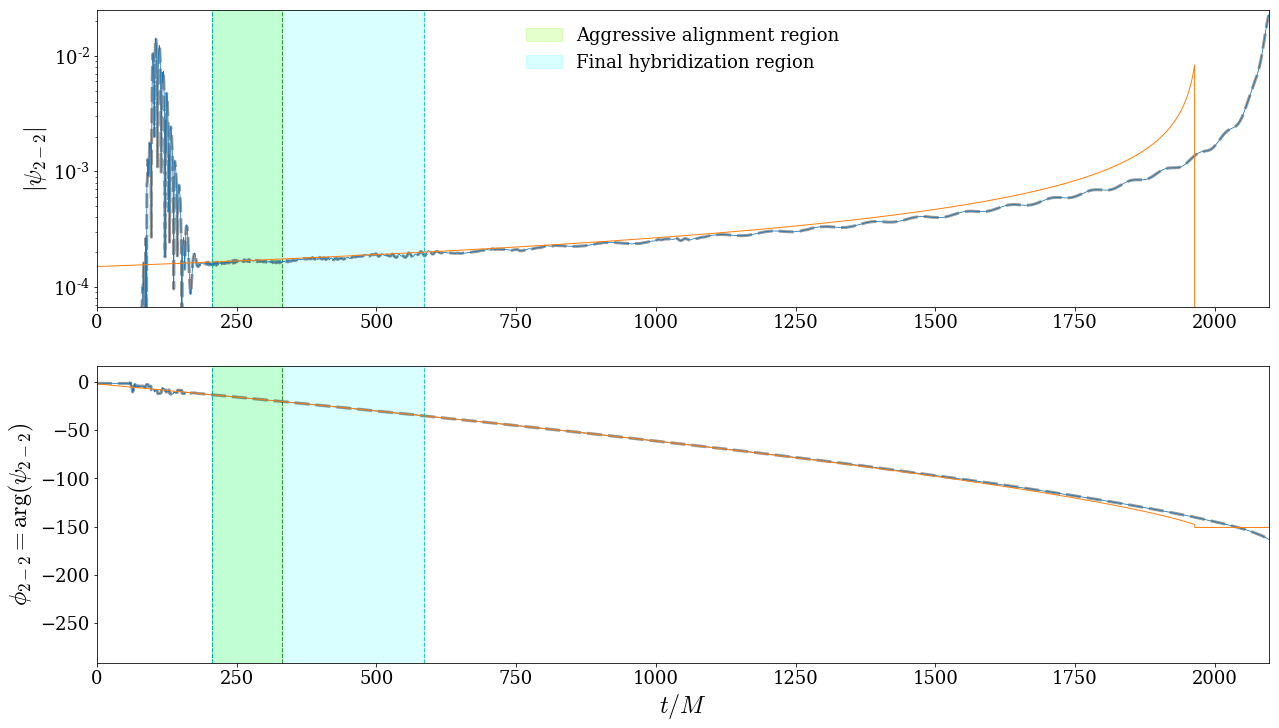

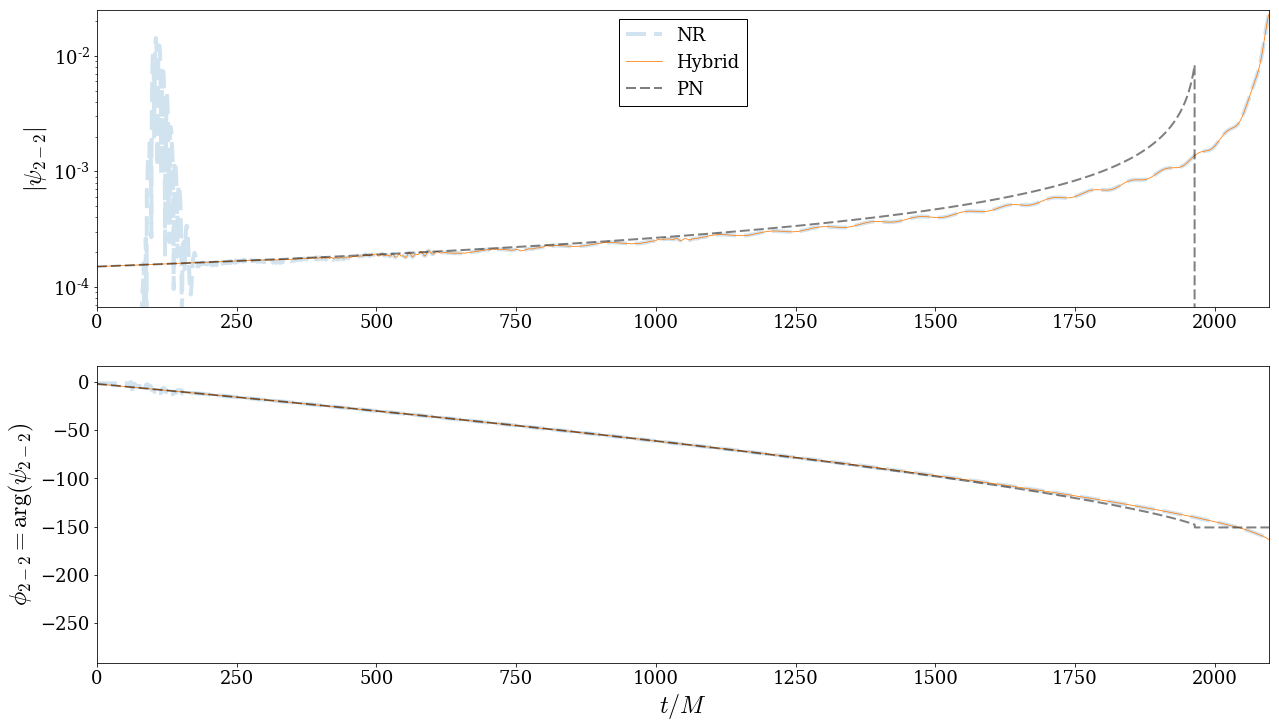

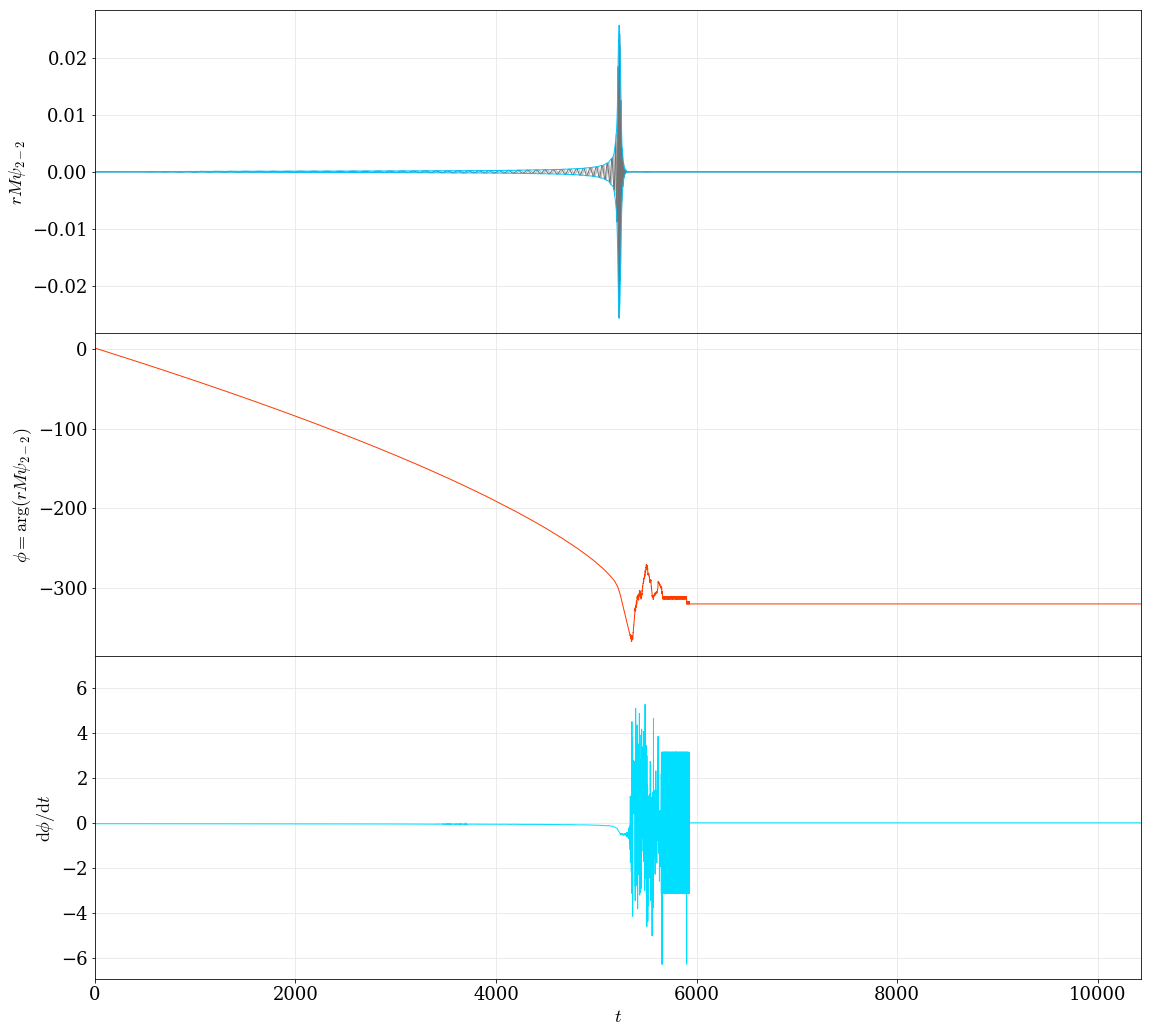

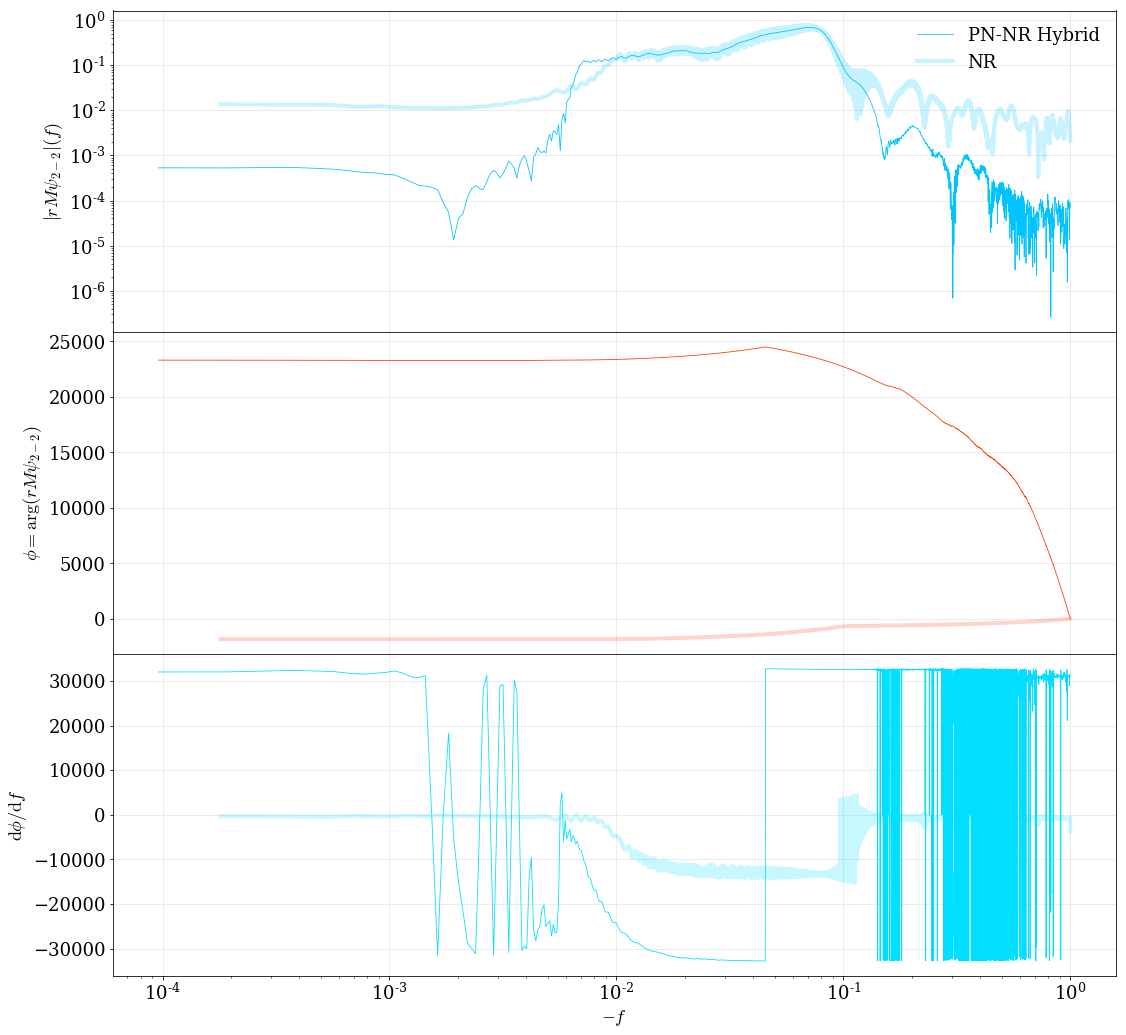


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
(__calc_multipole_hybrids__)>> Creating hybrid for: (2, -1)
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #

(__get_aligned_nr_pn_amp_phase__!)>> The PN phase will be shifted by 0.574590 (rad).
(__calc_single_multipole_hybrid__!)>> The NR data appares to be sufficiently smooth. No bridge model will be used.


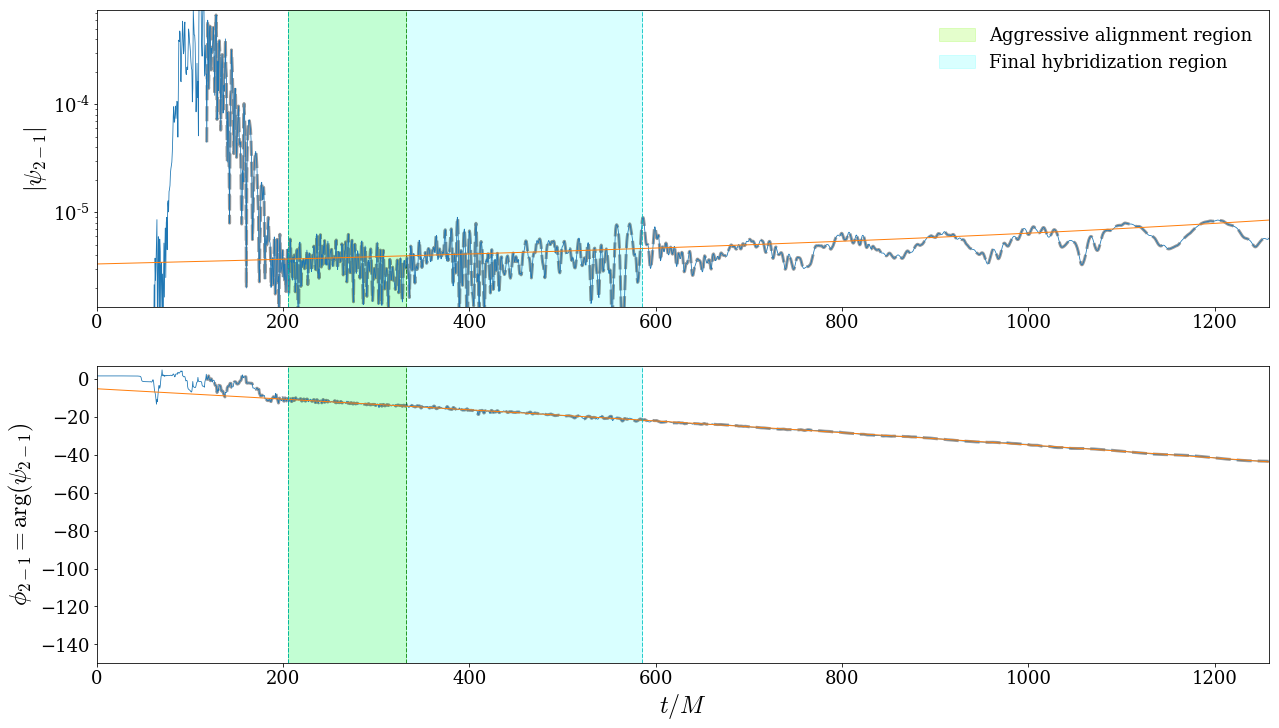

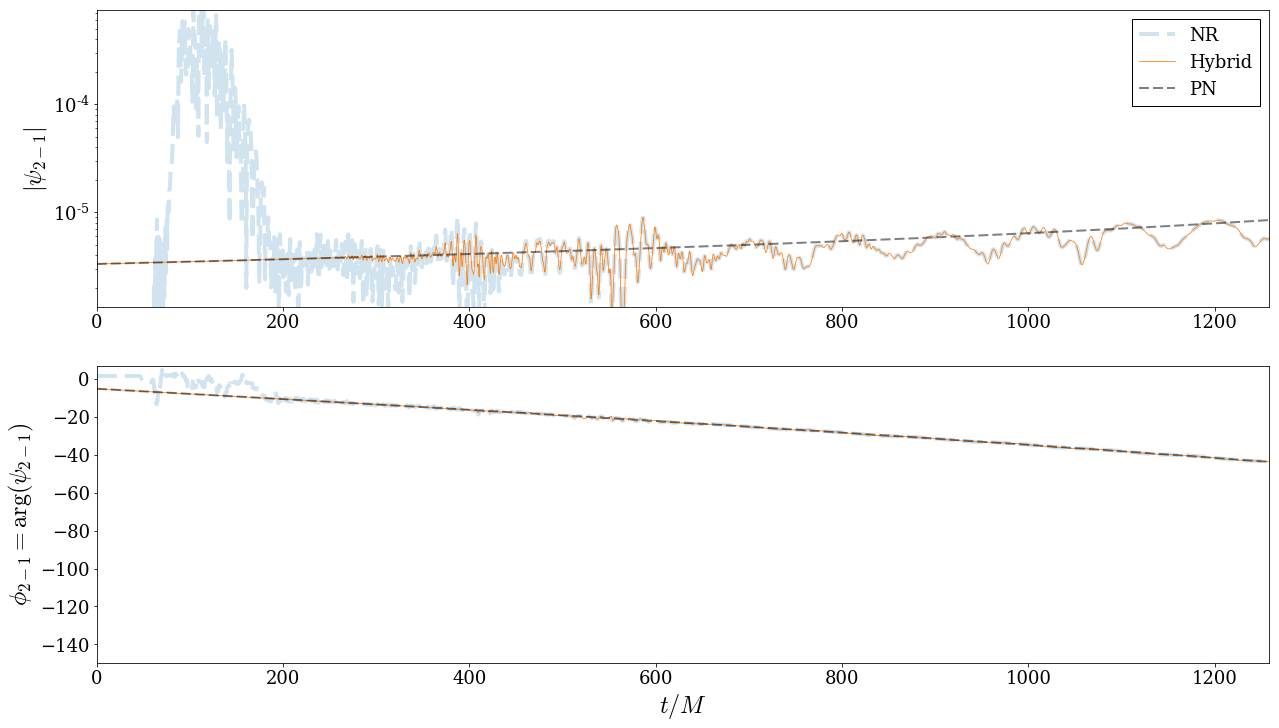

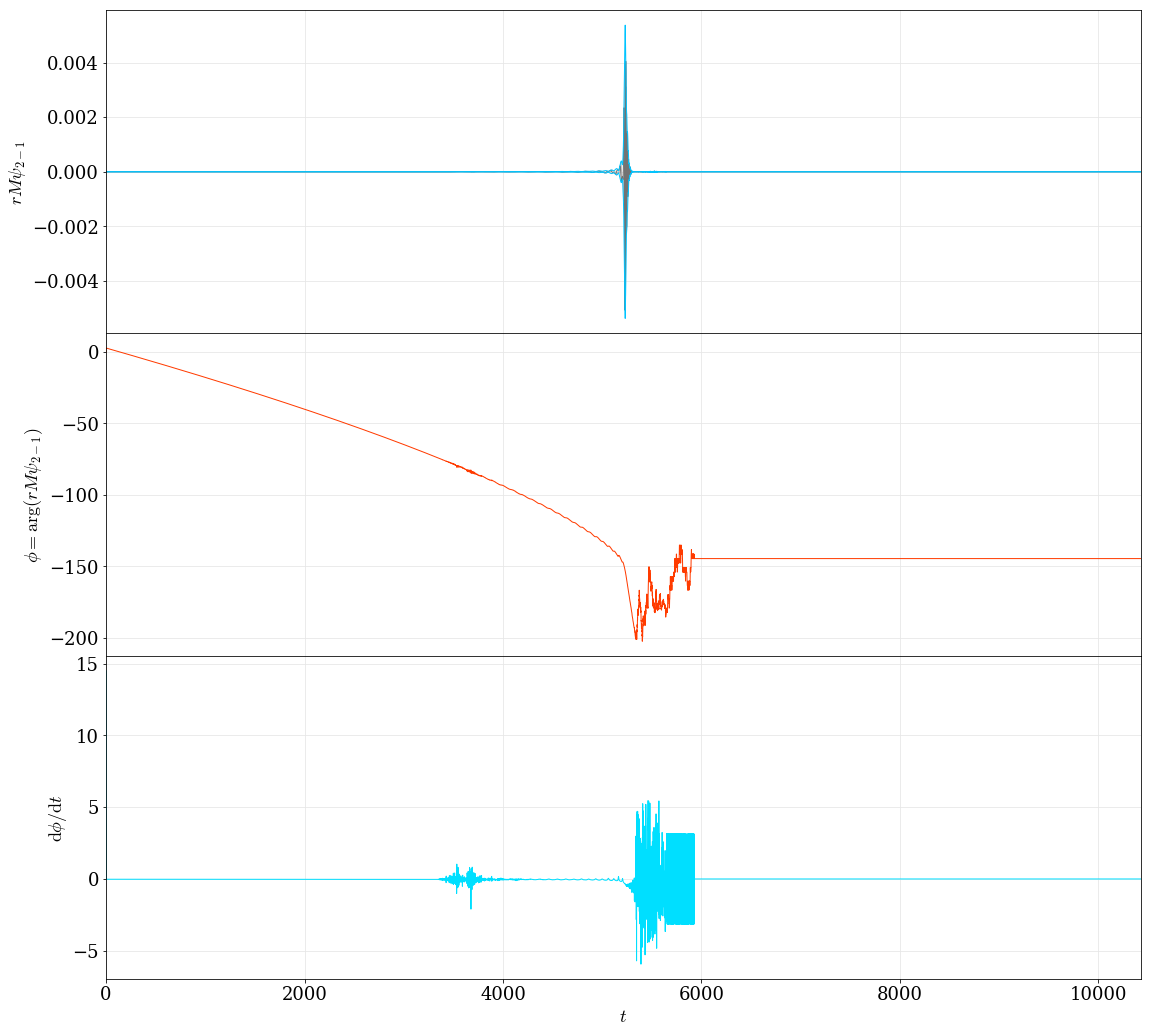

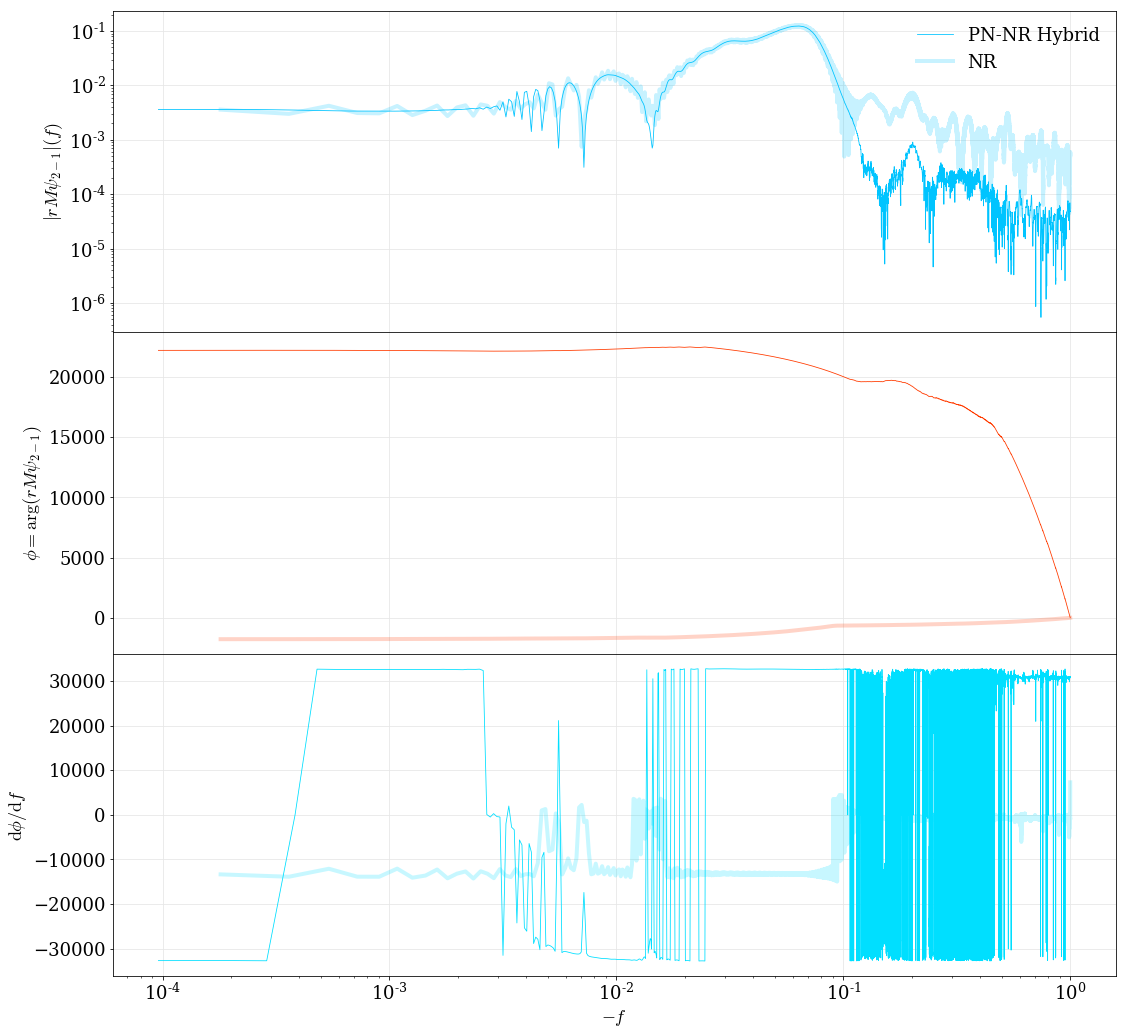


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
(__calc_multipole_hybrids__)>> Creating hybrid for: (2, 0)
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #

(__get_aligned_nr_pn_amp_phase__!)>> The PN phase will be shifted by 12.882080 (rad).


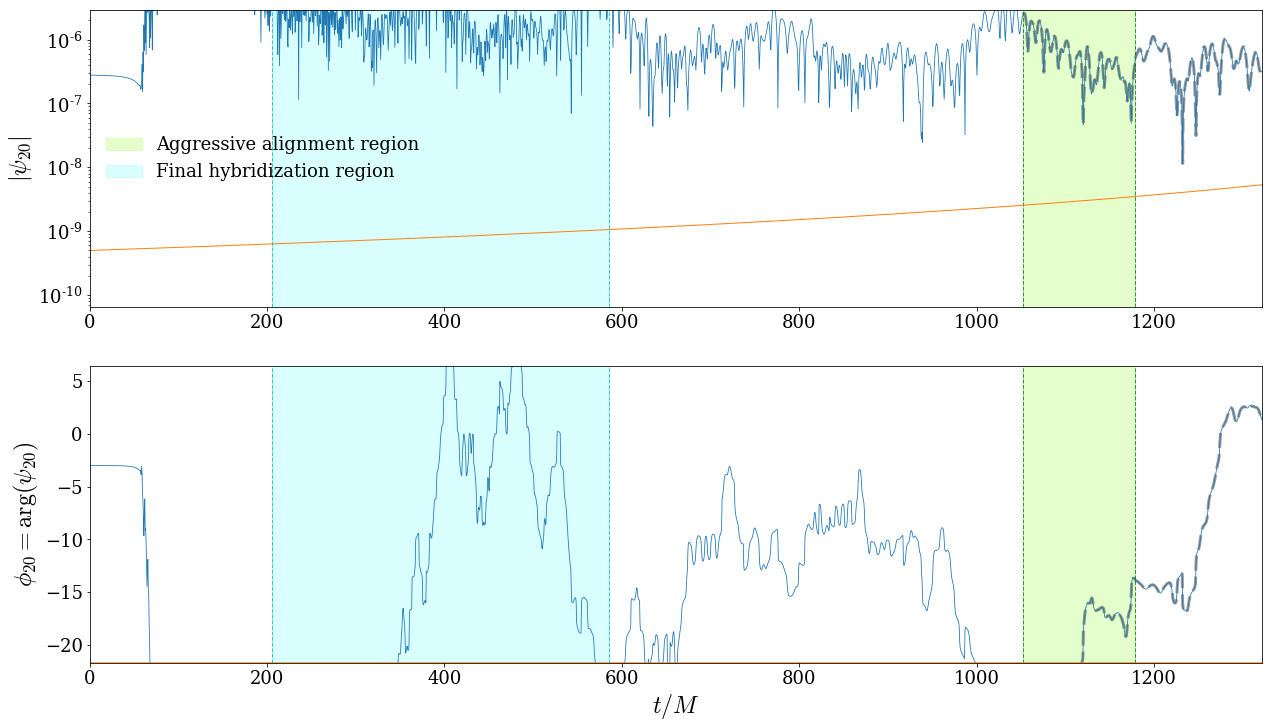

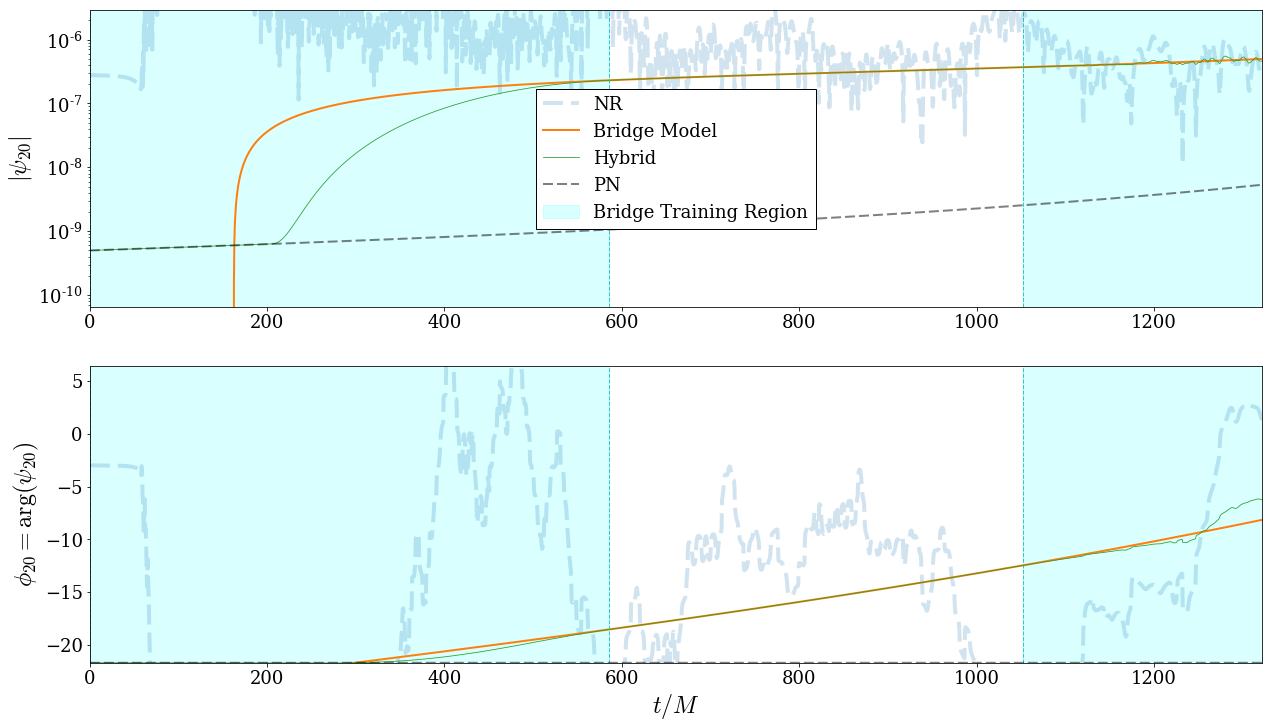

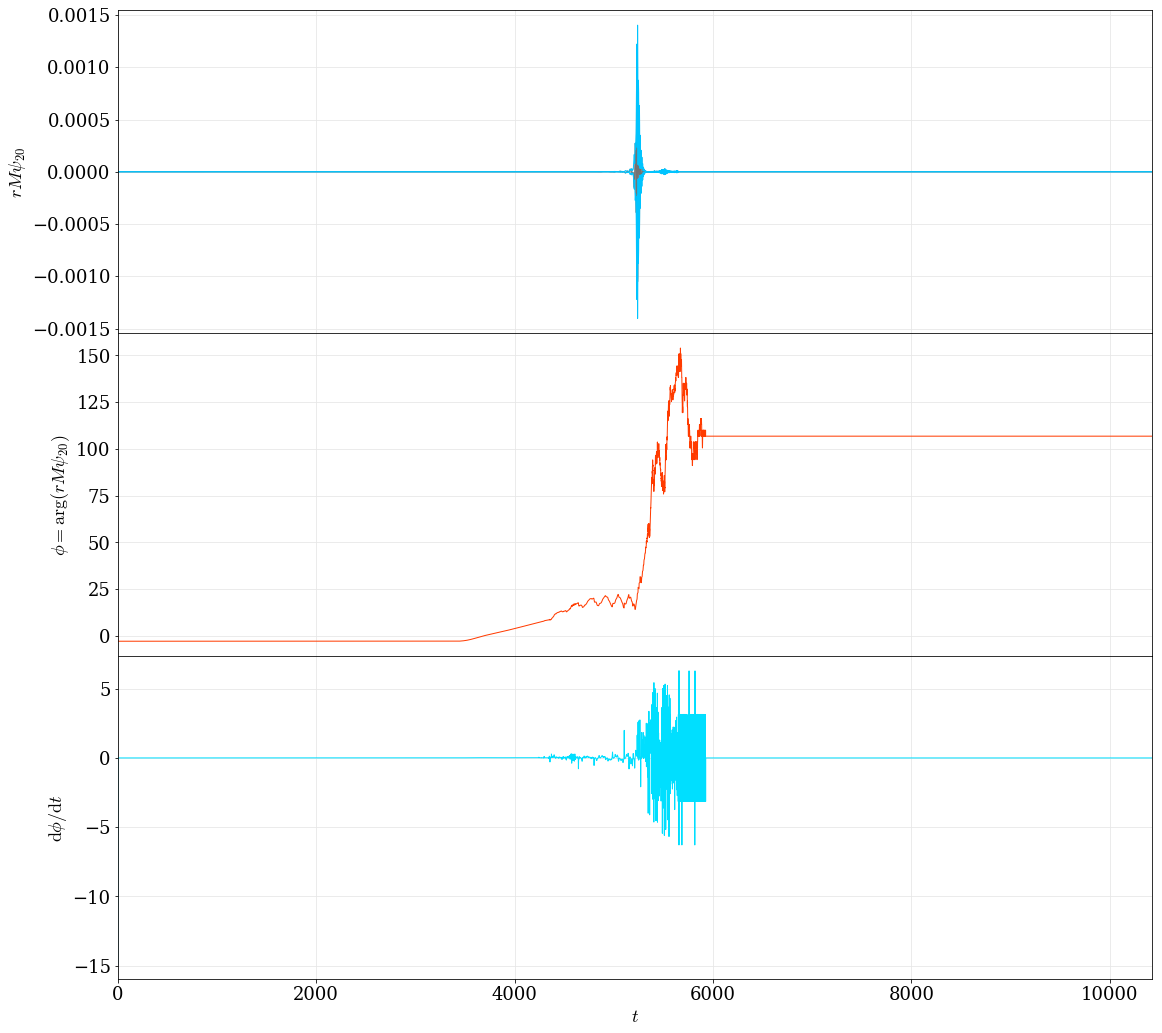

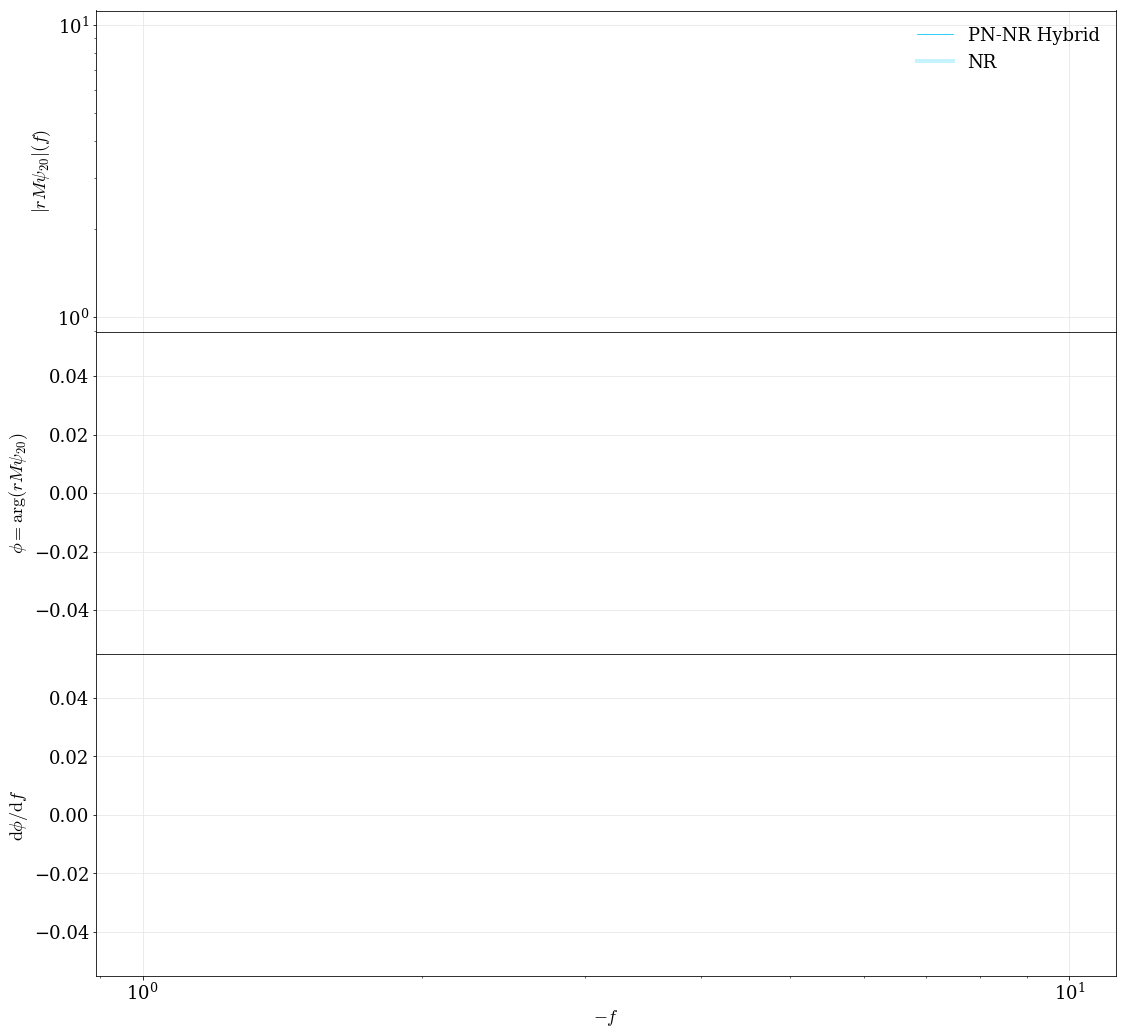


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
(__calc_multipole_hybrids__)>> Creating hybrid for: (2, 1)
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #

(smoothest_part!)>> the data appears to be smooth everywhere; please consider using this function's optional inputs to set your smoothing criteria
(__get_aligned_nr_pn_amp_phase__!)>> The PN phase will be shifted by -0.565015 (rad).
(__calc_single_multipole_hybrid__!)>> The NR data appares to be sufficiently smooth. No bridge model will be used.


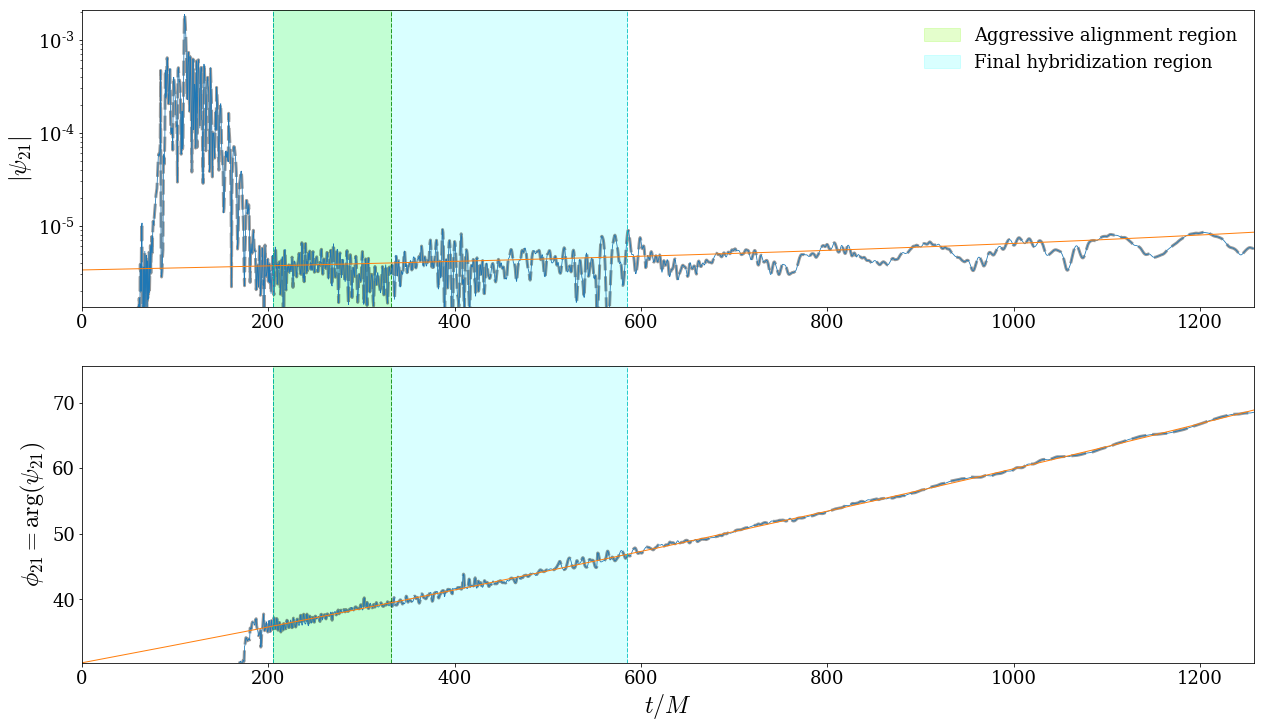

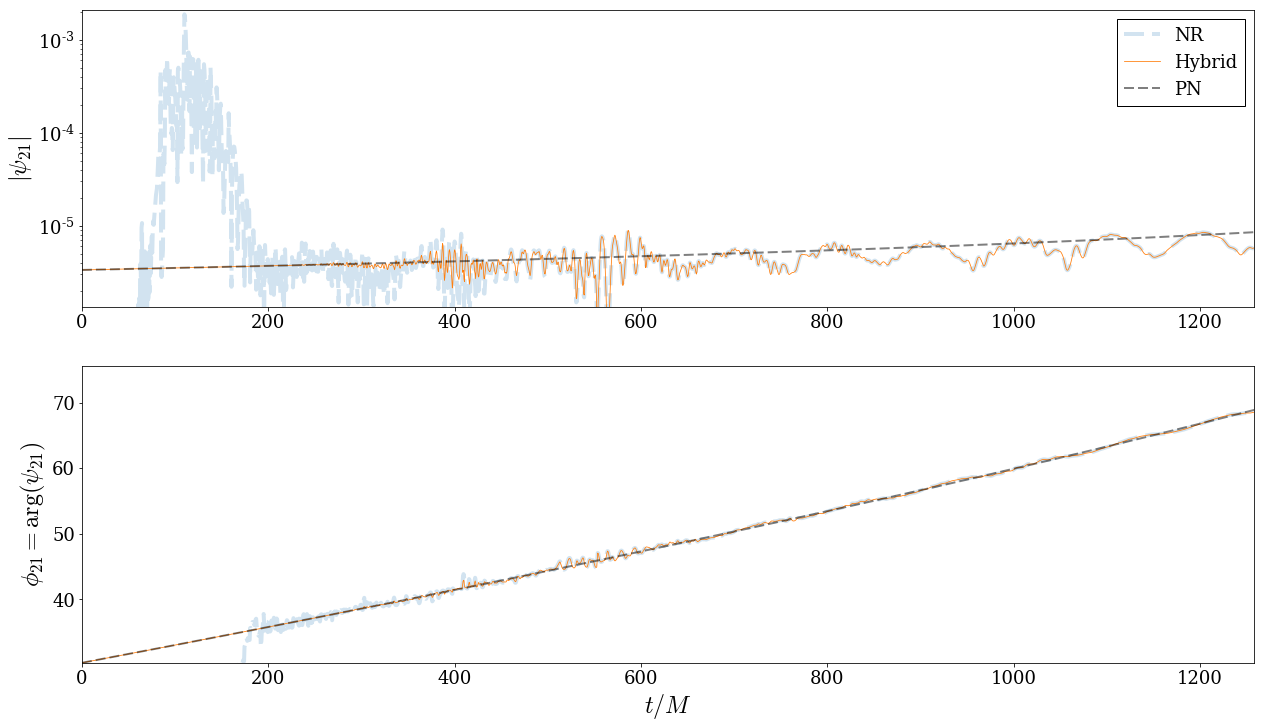

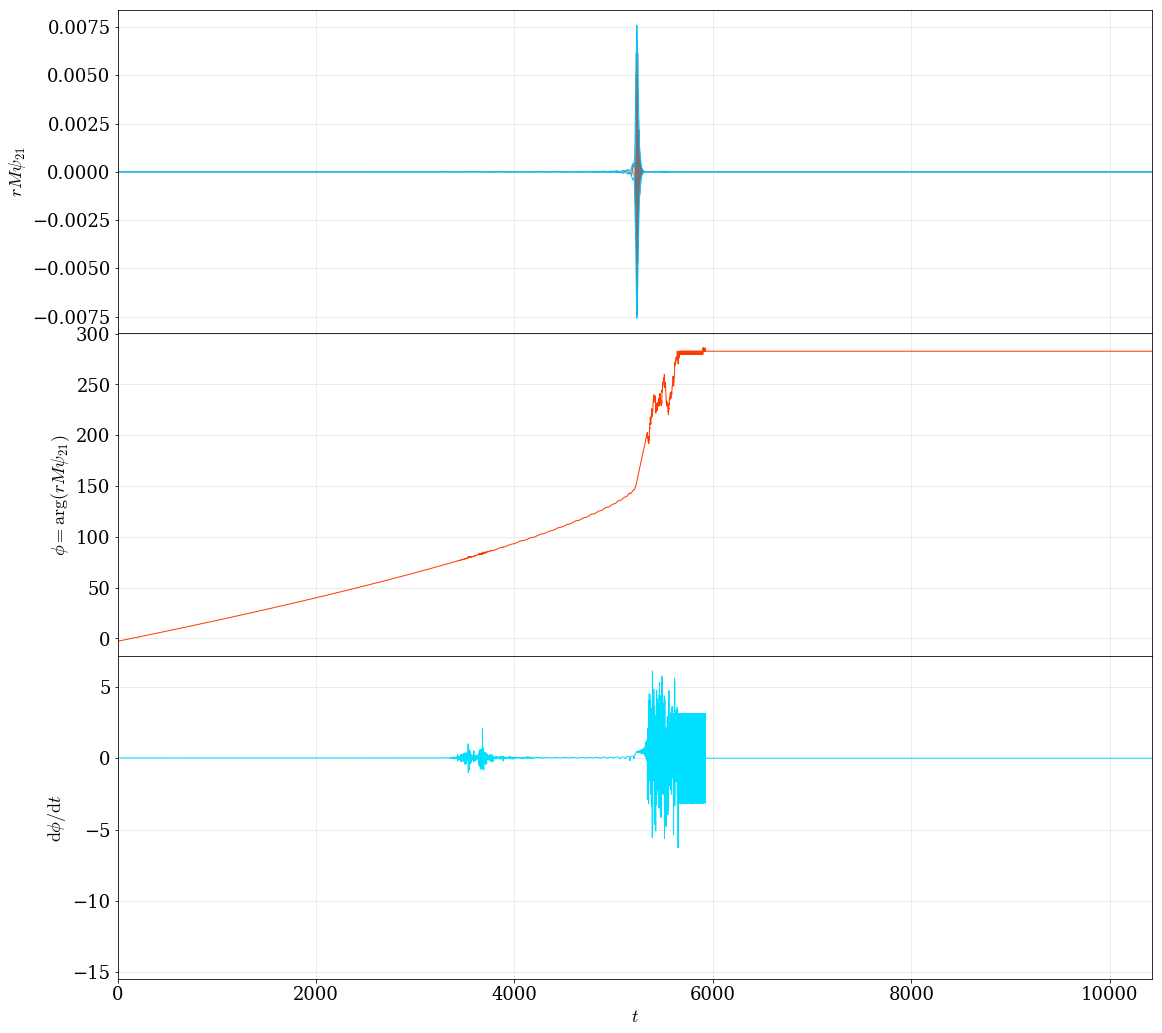

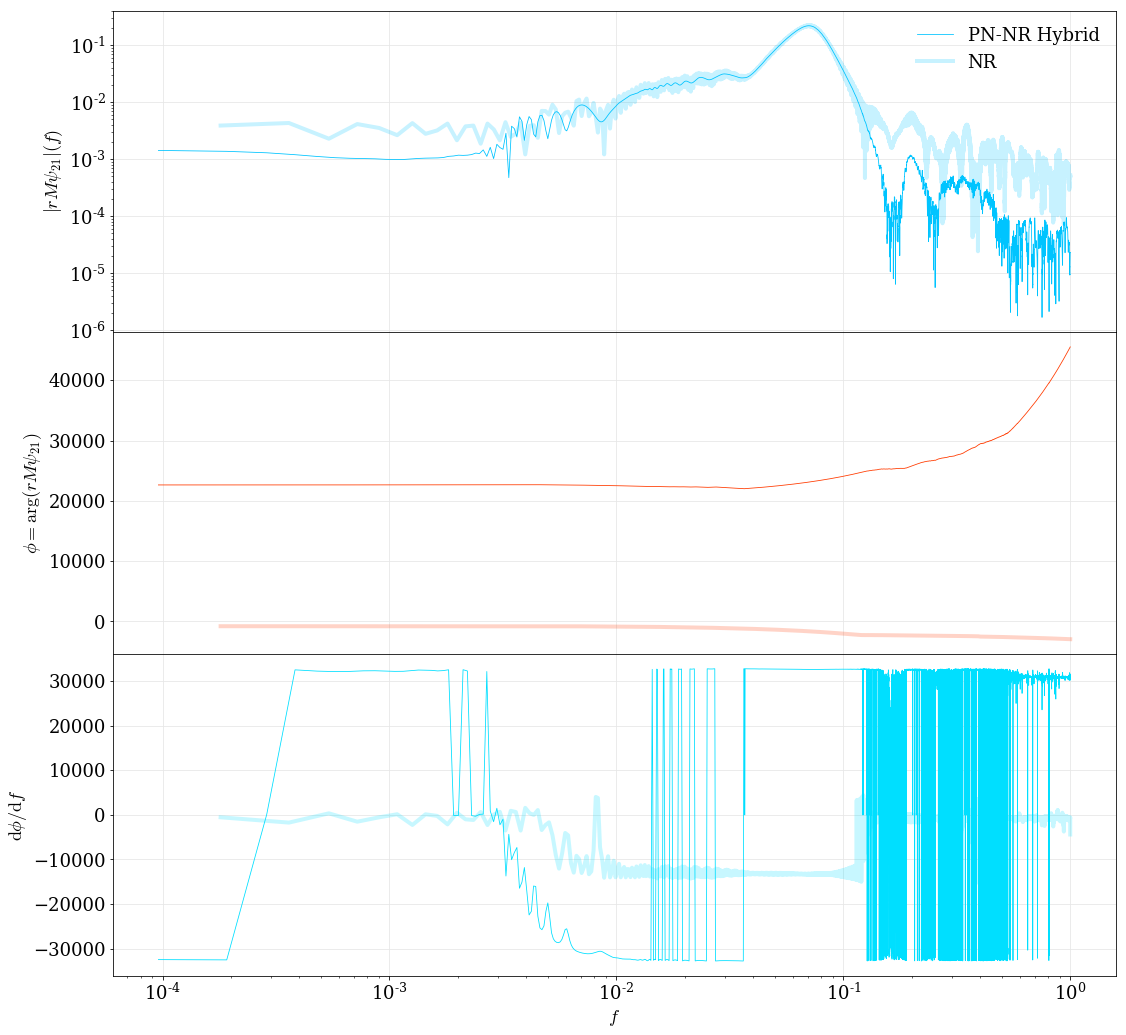


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
(__calc_multipole_hybrids__)>> Creating hybrid for: (2, 2)
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #

(__get_aligned_nr_pn_amp_phase__!)>> The PN phase will be shifted by -0.012573 (rad).
(__calc_single_multipole_hybrid__!)>> The NR data appares to be sufficiently smooth. No bridge model will be used.


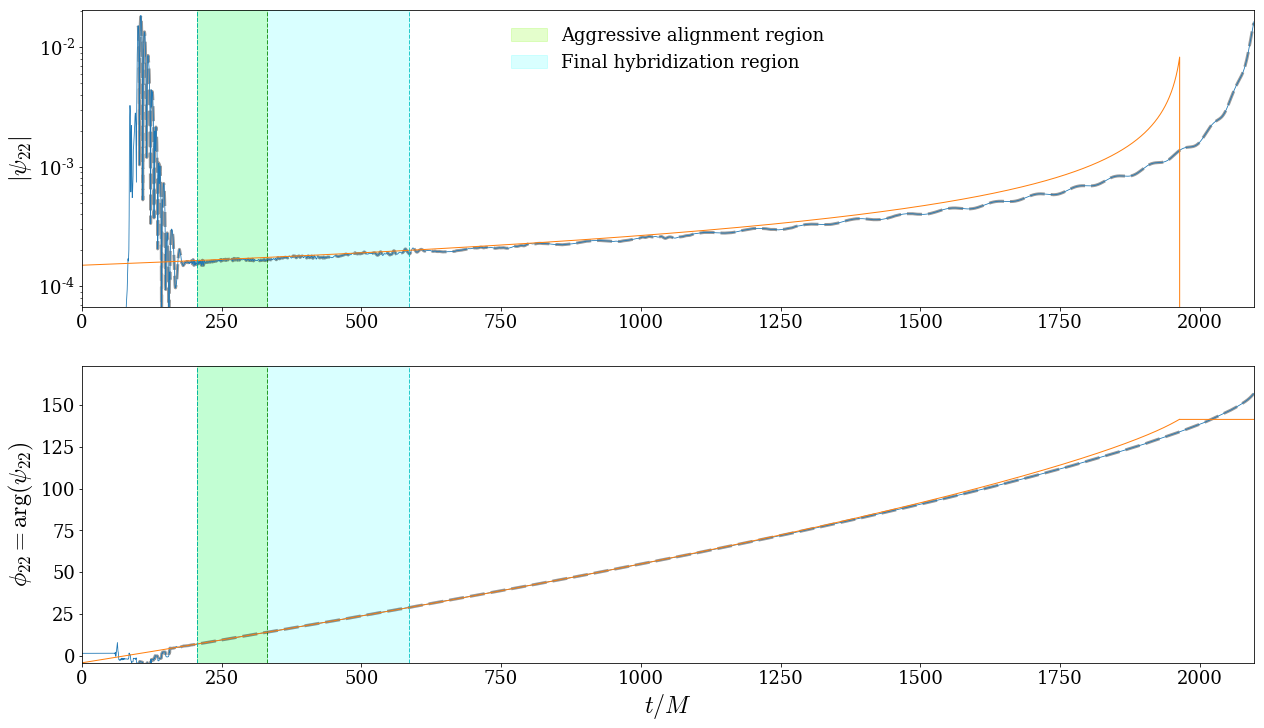

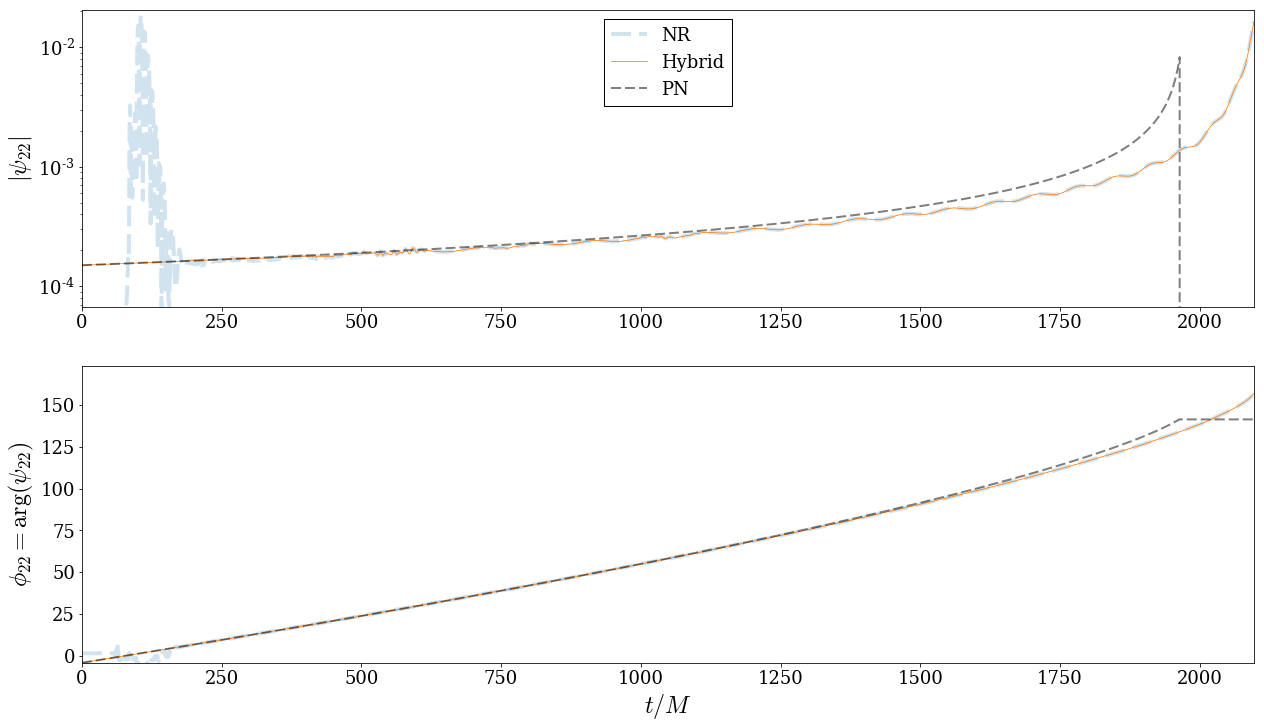

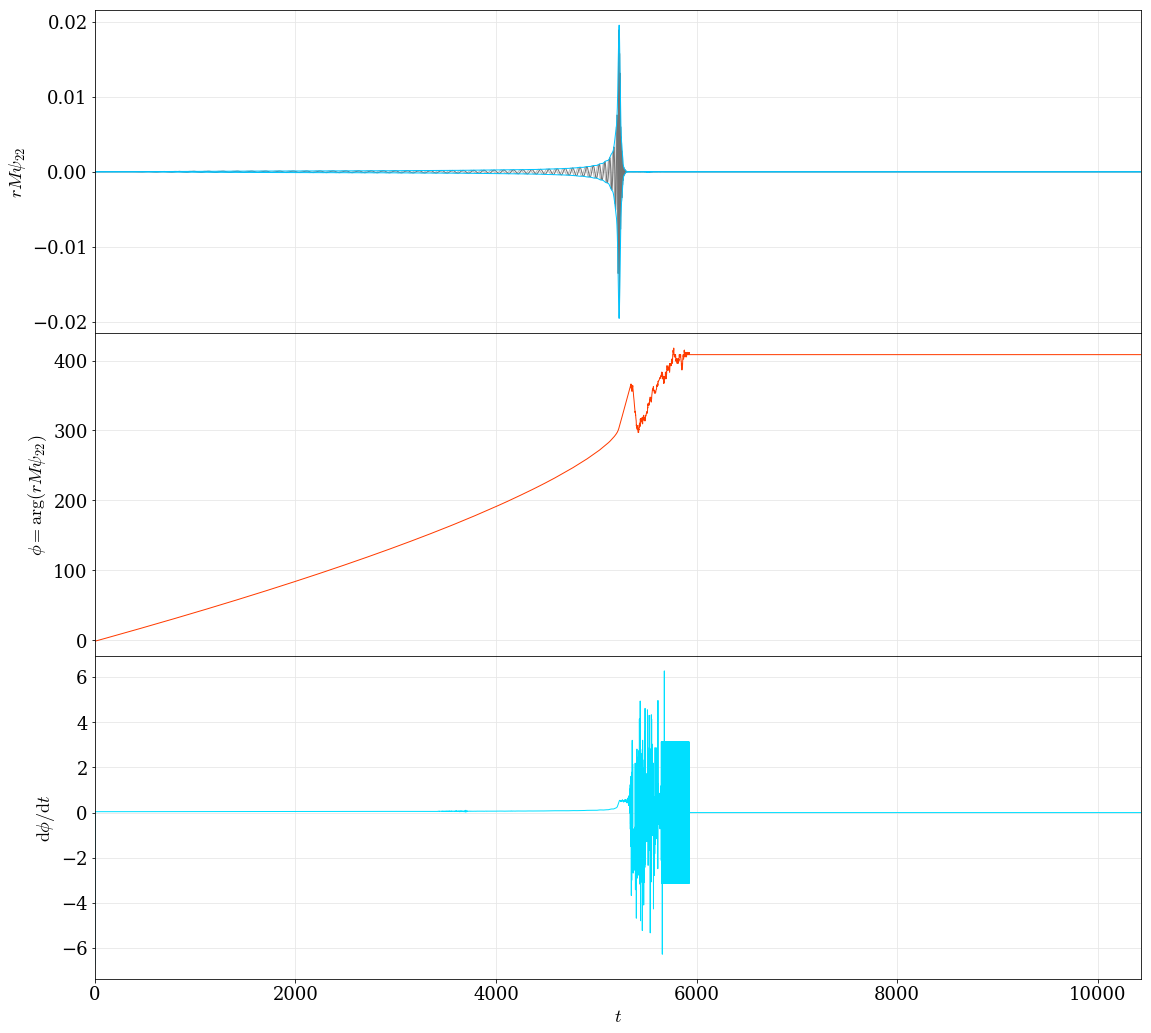

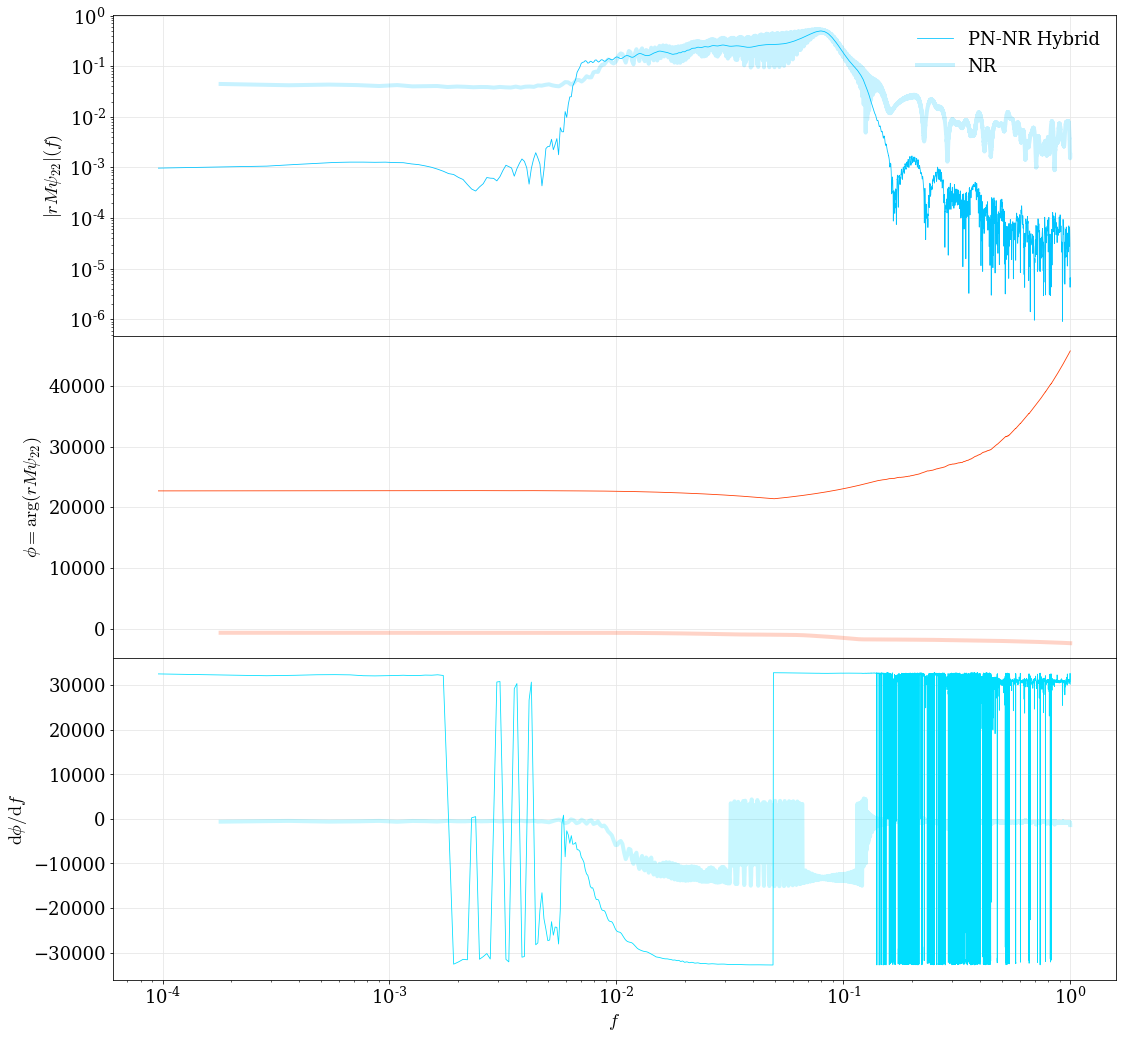

(romline!)>> N is 2, but it must be less than or equal to 3. We have set N=3. This course is often desired in cases where N=2 is naively given.
(__calc_multipole_hybrids__)>> Calculating hybrid strain.
(calchlm)>> w2-2 = m*w22/2 = -0.039708 (this is the lower frequency used for FFI method [arxiv:1006.1632v3])
(gwylm.calchlm)>> The user should note that there is no minus sign used in front of the double time integral for strain (i.e. Eq 4 of arxiv:1006.1632). This differs from Eq 3.4 of arxiv:0707.4654v3. The net effect is a rotation of the overall polarization of pi degrees. The user should also note that there is no minus sign applied to h_cross meaning that the user must be mindful to write h_plus-1j*h_cross when appropriate.
(calchlm)>> w2-1 = m*w22/2 = -0.019854 (this is the lower frequency used for FFI method [arxiv:1006.1632v3])
(gwylm.calchlm)>> The user should note that there is no minus sign used in front of the double time integral for strain (i.e. Eq 4 of arxiv:1006.1632). T

In [40]:
hyb_y,_ = y.hybridize(plot=True)

In [41]:
a.raw_metadata.show()

(show)>> 0doutput = ['ADM_mass', '#', 'ham'] 
(show)>> __unstring__ = False 
(show)>> 0doutputmaxpos = bssn_eta 
(show)>> trajectory2 = traj_2.l12.gz 
(show)>> trajectory1 = traj_1.l15.gz 
(show)>> 1doutput = ['bssn_eta', 'rpsi4', 'ipsi4', 'ham', 'momx', '#', 'alpha', 'betax', 'betay', 'bssn_phi', 'rpsi4', 'ipsi4'] 
(show)>> punctures_ps_file = /cosma/home/dp034/dc-thom8/BAM/production_runs/q8a08/Theta90/dP0/q8a08t90D.psid 
(show)>> bssn_shiftalphapower = 0.0 
(show)>> source_dir = ['/mnt/hogshead/NR_data/ReducedData-hogshead/q8/different_starting_frequency/q8a08t90dP0_T_96_384/', '/mnt/hogshead/NR_data/ReducedData-hogshead/q8/different_starting_frequency/q8a08t90dP0_T_96_384/'] 
(show)>> invariants_compute_modes = yes 
(show)>> AHmod_nhorizons = 2 
(show)>> amr = ['bo', 'newfmr', 'move'] 
(show)>> 5,2 = ['Psi4ModeDecomp/psi3col.r1.l7.l5.m2.gz', 'Psi4ModeDecomp/psi3col.r2.l7.l5.m2.gz', 'Psi4ModeDecomp/psi3col.r3.l7.l5.m2.gz', 'Psi4ModeDecomp/psi3col.r4.l7.l5.m2.gz', 'Psi4ModeDecomp/psi

(0.01, 0.3)

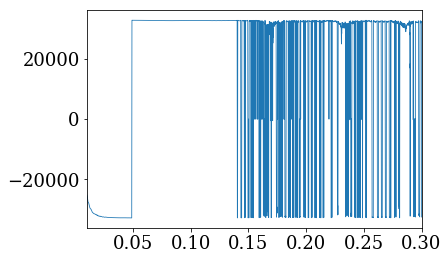

In [43]:
plot(hyb_y.f,hyb_y[2,2]['psi4'].fd_dphi)
xlim(0.01,0.3)

In [39]:
hyb_y

(<nrutils.core.nrsc.gwylm instance at 0x138262e10>,
 <nrutils.manipulate.hybridize.make_pnnr_hybrid instance at 0x1396dbc80>)